In [1]:
# from graphviper.dask.client import local_client
# viper_client = local_client(cores=4, memory_limit="4GB")

import dask
dask.config.set(scheduler="synchronous")

In [2]:
from xradio.image.image import (
    make_empty_sky_image
)
import numpy as np
import xarray as xr

arcsec_to_rad = np.pi/180/3600

im_xds = make_empty_sky_image(
    phase_center=[0.6, -0.2],
    image_size=[1024, 1024],
    cell_size=[arcsec_to_rad, arcsec_to_rad],
    chan_coords=np.linspace(1.0e11, 1.1e11, 16),
    pol_coords=["I"],
    time_coords=[0],
)

im_xds

<xarray.Dataset> Size: 17MB
Dimensions:          (time: 1, polarization: 1, frequency: 16, l: 1024, m: 1024)
Coordinates:
  * time             (time) float64 8B 0.0
  * polarization     (polarization) <U1 4B 'I'
  * frequency        (frequency) float64 128B 1e+11 1.007e+11 ... 1.1e+11
    velocity         (frequency) float64 128B 1.518e+07 1.328e+07 ... -1.328e+07
  * l                (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
    right_ascension  (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
    declination      (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
Data variables:
    *empty*
Attributes:
    direction:        {'reference': {'type': 'sky_coord', 'frame': 'FK5', 'eq...
    active_mask:      
    beam:             None
    object_name:      
    obsdate:          {'type': 'time', 'scale': 'UTC', 'format': 'MJD', 'valu...
    observer:         Karl Jansky
    pointing_center:  {'value': [0.6, -0.2], 'initial': True}
    description:      
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    history:          None

In [3]:
import dask.array as da
sky = da.random.random_sample(
    [1,1,16,1024,1024], chunks=[1,1,2,1024,1024]
).astype("float32")
xda = xr.DataArray(sky, coords=im_xds.coords, dims=im_xds.dims)
im_xds["SKY"] = xda
input_data = {"img": im_xds}
im_xds

<xarray.Dataset> Size: 84MB
Dimensions:          (time: 1, polarization: 1, frequency: 16, l: 1024, m: 1024)
Coordinates:
  * time             (time) float64 8B 0.0
  * polarization     (polarization) <U1 4B 'I'
  * frequency        (frequency) float64 128B 1e+11 1.007e+11 ... 1.1e+11
    velocity         (frequency) float64 128B 1.518e+07 1.328e+07 ... -1.328e+07
  * l                (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
    right_ascension  (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
    declination      (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
Data variables:
    SKY              (time, polarization, frequency, l, m) float32 67MB dask.array<chunksize=(1, 1, 2, 1024, 1024), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'type': 'sky_coord', 'frame': 'FK5', 'eq...
    active_mask:      
    beam:             None
    object_name:      
    obsdate:          {'type': 'time', 'scale': 'UTC', 'format': 'MJD', 'valu...
    observer:         Karl Jansky
    pointing_center:  {'value': [0.6, -0.2], 'initial': True}
    description:      
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    history:          None

In [4]:
from xradio.image import write_image
import shutil
import os

zarr_name = "test.zarr"
if os.path.exists(zarr_name):
    shutil.rmtree(zarr_name)
write_image(im_xds, zarr_name, "zarr")

In [6]:
from graphviper.graph_tools.coordinate_utils import make_parallel_coord
from toolviper.utils.display import dict_to_html
from IPython.display import HTML, display

parallel_coords = {}
n_chunks = 4
parallel_coords["frequency"] = make_parallel_coord(
    coord=im_xds.frequency, n_chunks=n_chunks
)
display(HTML(dict_to_html(parallel_coords["frequency"])))

In [7]:
from graphviper.graph_tools.coordinate_utils import interpolate_data_coords_onto_parallel_coords
node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(parallel_coords, input_data)
display(HTML(dict_to_html(node_task_data_mapping)))

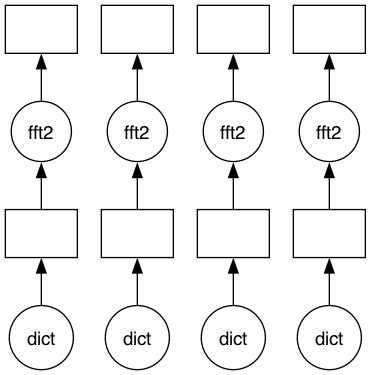

In [8]:
from graphviper.graph_tools.map import map
import dask


def _fft2(input_params):
    display(HTML(dict_to_html(input_params)))

    from xradio.image import load_image
    if input_params["input_data"] is None: #Load 
        img_xds = load_image(
            input_params["input_data_store"], block_des=input_params["data_selection"]["img"]
        )
    else:
        img_xds = input_params["input_data"]['img'] #In memory

    display(img_xds)

    fft_plane = (img_xds['SKY'].dims.index(input_params["axes"][0]),img_xds['SKY'].dims.index(input_params["axes"][1]))
    print('fft_plane',fft_plane)
    aperture = np.fft.fftshift(
        np.fft.fft2(
            np.fft.ifftshift(img_xds.SKY, axes=fft_plane),
            axes=fft_plane
        ), axes=fft_plane
     ).real
    
    img_xds['APERTURE'] = xr.DataArray(aperture, dims=('time','polarization','frequency','u','v'))

    return img_xds
   
    

input_params = {}
input_params["input_data_store"] = zarr_name
input_params["axes"] = ('l','m')#(3,4)

viper_graph = map(
    input_data=input_data,
    node_task_data_mapping=node_task_data_mapping,
    node_task=_fft2,
    input_params=input_params,
    in_memory_compute=False
)
from graphviper.graph_tools import generate_dask_workflow
dask_graph = generate_dask_workflow(viper_graph)
dask.visualize(dask_graph, filename="map_graph")


In [9]:
aperture_list = dask.compute(dask_graph)

<xarray.Dataset> Size: 34MB
Dimensions:          (time: 1, polarization: 1, frequency: 4, l: 1024, m: 1024)
Coordinates:
    declination      (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
  * frequency        (frequency) float64 32B 1.08e+11 1.087e+11 ... 1.1e+11
  * l                (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * polarization     (polarization) <U1 4B 'I'
    right_ascension  (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
  * time             (time) float64 8B 0.0
    velocity         (frequency) float64 32B -7.59e+06 -9.487e+06 ... -1.328e+07
Data variables:
    SKY              (time, polarization, frequency, l, m) float32 17MB 0.243...
Attributes:
    active_mask:      
    beam:             None
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

fft_plane (3, 4)


<xarray.Dataset> Size: 34MB
Dimensions:          (time: 1, polarization: 1, frequency: 4, l: 1024, m: 1024)
Coordinates:
    declination      (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
  * frequency        (frequency) float64 32B 1.027e+11 1.033e+11 ... 1.047e+11
  * l                (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * polarization     (polarization) <U1 4B 'I'
    right_ascension  (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
  * time             (time) float64 8B 0.0
    velocity         (frequency) float64 32B 7.59e+06 5.692e+06 ... 1.897e+06
Data variables:
    SKY              (time, polarization, frequency, l, m) float32 17MB 0.369...
Attributes:
    active_mask:      
    beam:             None
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

fft_plane (3, 4)


<xarray.Dataset> Size: 34MB
Dimensions:          (time: 1, polarization: 1, frequency: 4, l: 1024, m: 1024)
Coordinates:
    declination      (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
  * frequency        (frequency) float64 32B 1e+11 1.007e+11 1.013e+11 1.02e+11
  * l                (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * polarization     (polarization) <U1 4B 'I'
    right_ascension  (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
  * time             (time) float64 8B 0.0
    velocity         (frequency) float64 32B 1.518e+07 1.328e+07 ... 9.487e+06
Data variables:
    SKY              (time, polarization, frequency, l, m) float32 17MB 0.670...
Attributes:
    active_mask:      
    beam:             None
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

fft_plane (3, 4)


<xarray.Dataset> Size: 34MB
Dimensions:          (time: 1, polarization: 1, frequency: 4, l: 1024, m: 1024)
Coordinates:
    declination      (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
  * frequency        (frequency) float64 32B 1.053e+11 1.06e+11 ... 1.073e+11
  * l                (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * polarization     (polarization) <U1 4B 'I'
    right_ascension  (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
  * time             (time) float64 8B 0.0
    velocity         (frequency) float64 32B 0.0 -1.897e+06 ... -5.692e+06
Data variables:
    SKY              (time, polarization, frequency, l, m) float32 17MB 0.165...
Attributes:
    active_mask:      
    beam:             None
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

fft_plane (3, 4)


In [10]:
len(aperture_list[0])

4

In [11]:
aperture_list[0][0]

<xarray.Dataset> Size: 50MB
Dimensions:          (time: 1, polarization: 1, frequency: 4, l: 1024, m: 1024,
                      u: 1024, v: 1024)
Coordinates:
    declination      (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
  * frequency        (frequency) float64 32B 1e+11 1.007e+11 1.013e+11 1.02e+11
  * l                (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * polarization     (polarization) <U1 4B 'I'
    right_ascension  (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
  * time             (time) float64 8B 0.0
    velocity         (frequency) float64 32B 1.518e+07 1.328e+07 ... 9.487e+06
Dimensions without coordinates: u, v
Data variables:
    SKY              (time, polarization, frequency, l, m) float32 17MB 0.670...
    APERTURE         (time, polarization, frequency, u, v) float32 17MB 195.6...
Attributes:
    active_mask:      
    beam:             None
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

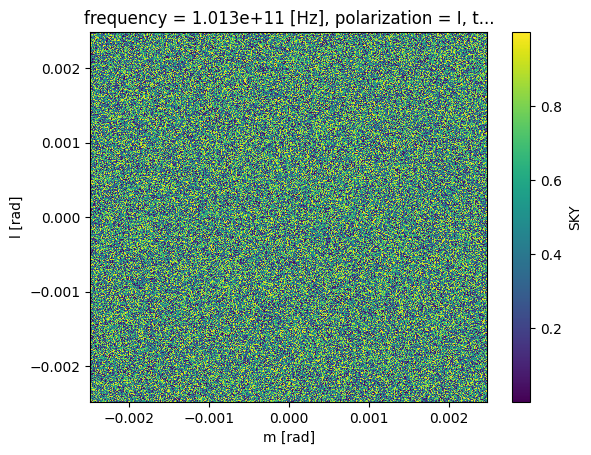

In [12]:
aperture_list[0][0]['SKY'].sel(polarization='I').isel(frequency=2,time=0).plot()

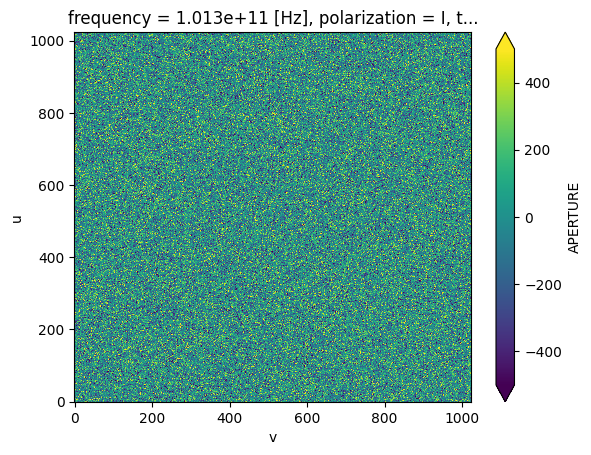

In [13]:
aperture_list[0][0]['APERTURE'].sel(polarization='I').isel(frequency=2,time=0).plot(vmin=-500, vmax=500)